In [1]:
# Allow reload of objects
%load_ext autoreload
%autoreload
from pelenet.utils import Utils
from pelenet.experiments.readout import ReadoutExperiment

# Official modules
import numpy as np
import nxsdk.api.n2a as nx
import matplotlib
import matplotlib.pyplot as plt
import os
from time import time

In [2]:
# Initilizes the experiment and utils
utils = Utils.instance()
exp = ReadoutExperiment()

In [3]:
# Build network
exp.build()

# Get spectral radius
utils.getSpectralRadius(exp.net.initialWeights)

/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


2.22

In [4]:
# Compile network
compiler = nx.N2Compiler()
board = compiler.compile(exp.net.nxNet)

In [5]:
from nxsdk.graph.processes.phase_enums import Phase

snipDir = os.path.abspath(os.path.join('pelenet', 'snips'))

# Initialize reset SNIP for LMT1 (reset injection)
reset_init = board.createSnip(
    name='init',
    cFilePath=snipDir + "/reset_init.c",
    includeDir=snipDir,
    funcName='initialize_reset',
    phase=Phase.EMBEDDED_INIT,
    lmtId=0,
    chipId=0)

reset_init2 = board.createSnip(
    name='init2',
    cFilePath=snipDir + "/reset_init.c",
    includeDir=snipDir,
    funcName='initialize_reset',
    phase=Phase.EMBEDDED_INIT,
    lmtId=0,
    chipId=1)

# Reset SNIP
board.createSnip(
    name='reset',
    cFilePath=snipDir + "/reset.c",
    includeDir=snipDir,
    guardName='do_reset',
    funcName='reset',
    phase=Phase.EMBEDDED_MGMT,
    lmtId=0,
    chipId=0)

board.createSnip(
    name='reset2',
    cFilePath=snipDir + "/reset.c",
    includeDir=snipDir,
    guardName='do_reset',
    funcName='reset',
    phase=Phase.EMBEDDED_MGMT,
    lmtId=0,
    chipId=1)


In [6]:
# Create channel for init data with buffer size of 3
initResetChannel = board.createChannel(bytes('initreset', 'utf-8'), "int", 3)
initResetChannel2 = board.createChannel(bytes('initreset2', 'utf-8'), "int", 3)

# Connect channel to init snip
initResetChannel.connect(None, reset_init)
initResetChannel2.connect(None, reset_init2)

# Start board
board.start()

# Write data to channel
initResetChannel.write(3, [exp.p.numCoresPerChip, exp.p.totalTrialSteps, 1])  # number of cores per chip, reset interval, activate snip (0/1)
initResetChannel2.write(3, [exp.p.numCoresPerChip, exp.p.totalTrialSteps, 1])

INFO:DRV:  Connecting to 127.0.0.1:41141
INFO:DRV:      Host server up..............Done 0.05s
INFO:DRV:      Encoding axons/synapses.....Done 14.89s
Compiling in directory : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1579894132.522406
Include dir is : /home/seq/05-reward/v0.x/pelenet/snips -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/
Compiling -c /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1579894132.522406/initnetwork_0_0.c
gcc -Wall -I/home/seq/05-reward/v0.x/pelenet/snips -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c9

INFO:DRV:      Compiling Embedded snips....Done 0.54s
INFO:HST:  Using Kapoho Bay serial number 308
INFO:HST:  Args chip=0 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1579894132.522406/launcher_chip0_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Args chip=1 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1579894132.522406/launcher_chip1_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 1.70s
INFO:DRV:      Encoding probes.............Done 8.18ms


In [7]:
# Run network
#exp.run()

board.run(exp.p.totalSteps)

#board.finishRun()
board.disconnect()

exp.net.postProcessing()

INFO:DRV:      Transferring spikes.........Done 2.00ms
INFO:DRV:      Transferring probes.........Done 0.04s
INFO:DRV:      Configuring registers.......Done 15.47s
INFO:HST:  chip=0 cpu=0 Transfered values 128, 400, 1 
INFO:HST:  chip=1 cpu=0 Transfered values 128, 400, 1 
INFO:DRV:      Executing...................Done 413.07s
INFO:DRV:      Processing timeseries.......Done 16.69s
INFO:DRV:  Executor: 1200 timesteps........Done 445.29s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:HST:  chip=1 cpu=0 halted, status=0x0


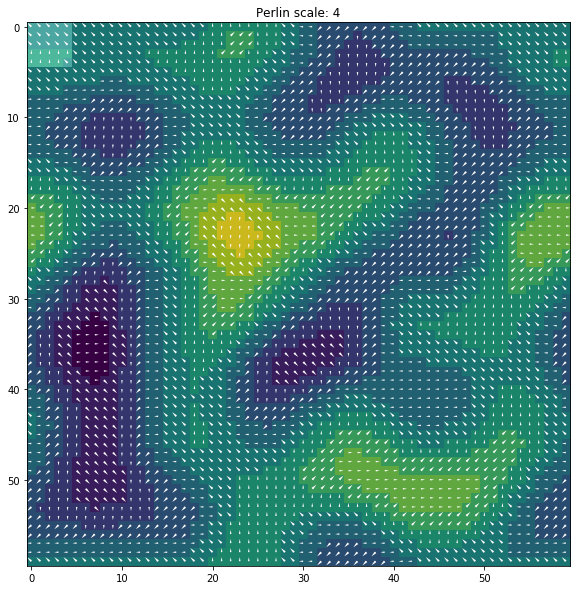

In [8]:
exp.net.plot.landscape()

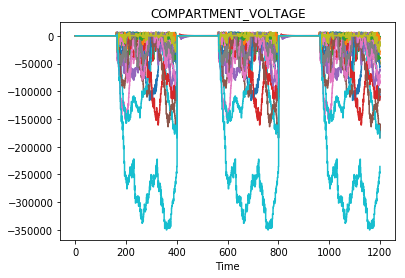

In [9]:
p = exp.net.exVoltageProbes[0].plot()

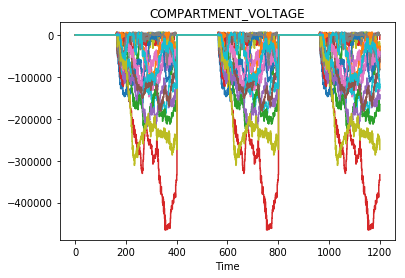

In [10]:
p = exp.net.inVoltageProbes[0].plot()

In [11]:
exp.net.exVoltageProbes[0].data[0,400:800]

array([      0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       1,       2,       3,       4,
             5,       6,       7,       8,       9,      10,      11,
            12,      13,      14,      15,      16,      17,      18,
            19,      20,      21,      22,      23,      24,      25,
            26,      27,      28,      29,      30,      31,      32,
            33,      34,      35,      36,      37,      38,      39,
            40,      41,      42,      43,      44,      45,      46,
            47,      48,      49,      50,      51,      52,      53,
            54,      55,      56,      57,      58,      59,      60,
            61,      62,      63,      64,      65,      66,      67,
            68,      69,      70,      71,      72,      73,      74,
            75,      76,      77,      78,      79,      80,      81,
            82,      83,      84,      85,      86,      87,      88,
            89,     

In [12]:
nev = len(exp.net.exVoltageProbes)
np.sum([exp.net.exVoltageProbes[i].data[:,225] for i in range(nev)])

-192626955

In [13]:
niv = len(exp.net.inVoltageProbes)
np.sum([exp.net.inVoltageProbes[i].data[:,225] for i in range(niv)])

-47227581

In [14]:
nev + niv

225

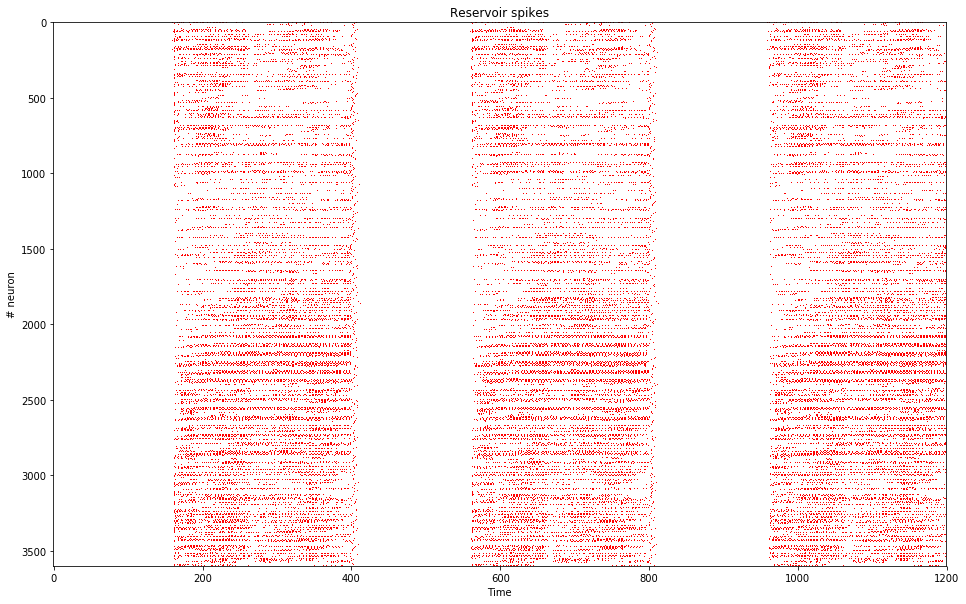

In [15]:
exp.net.plot.reservoirSpikeTrain()

In [16]:
#exp.net.plot.reservoirSpikeTrain(fr=160, to=400)

In [17]:
i = 10
print(np.sum(exp.net.exSpikeProbes[i].data[:,15:400]))
print(np.sum(exp.net.exSpikeProbes[i].data[:,415:800]))

489
489


In [18]:
print(exp.net.p.trialSteps)
print(exp.net.p.breakSteps)
print(exp.net.p.totalTrialSteps)
print(exp.p.totalSteps)

240
160
400
1200


In [19]:
#exp.net.cueSpikes

In [20]:
t1 = exp.net.exSpikeTrains[:,15:400]
t2 = exp.net.exSpikeTrains[:,415:800]
t3 = exp.net.exSpikeTrains[:,815:1200]
np.sum(np.abs(t1-t2))

0

In [21]:
np.sum(exp.net.exSpikeTrains[:,225:230])

2760

In [22]:
#print(exp.net.exVoltageProbes[0].data[:,0:20])

In [23]:
#print(exp.net.exSpikeProbes[1].data[:,245:265])

In [24]:
print(exp.net.exVoltageProbes[0].data[:,245:265])

[[  -3405   -7334    3265     256     257     256     257    5120     256
      257    1024     256     257    2048   -4196    2153   -2049    5220
   -12443  -10811]
 [    256     257    2048    2972    3850     256     257     256     257
      256     257     256     257     256     257  -19456   -1098  -18452
   -15503  -16794]
 [    256     257     256     257     256     257     256     257     256
      257     256     257     256     257     256     257     256     257
    -8192   -8816]
 [   5288     256     257    5120    2822    2684    1528     256     257
      256     257   -2048    4196    3991     256     257   -5120   -8966
   -19792  -17801]
 [    257    5120     256     257     256     257   -1024    -974     256
      257    6144    1748     256     257    3072   -7318    2256   -6047
   -13943   -7118]
 [  -3317     -83   -7246   -8940   -8503  -10135  -13736   -3849   -6733
     1788     256     257    1024   -7218  -10961  -40121  -43281  -48335
   -57238  -64683

In [25]:
print(exp.net.exVoltageProbes[0].data[:,490:510])

[[  81   82   83   84   85   86   87   88   89   90   91   92   93   94
    95   96   97   98   99  100]
 [  81   82   83   84   85   86   87   88   89   90   91   92   93   94
    95   96   97   98   99  100]
 [  81   82   83   84   85   86   87   88   89   90   91   92   93   94
    95   96   97   98   99  100]
 [  81   82   83   84   85   86   87   88   89   90   91   92   93   94
    95   96   97   98   99  100]
 [  81   82   83   84   85   86   87   88   89   90   91   92   93   94
    95   96   97   98   99  100]
 [  81   82   83   84   85   86   87   88   89   90   91   92   93   94
    95   96   97   98   99  100]
 [  81   82   83   84   85   86   87   88   89   90   91   92   93   94
    95   96   97   98   99  100]
 [  81   82   83   84   85   86   87   88   89   90   91   92   93   94
    95   96   97   98   99  100]
 [  81   82   83   84   85   86   87   88   89   90   91   92   93   94
    95   96   97   98   99  100]
 [  81   82   83   84   85   86   87   88   89   90   9

In [26]:
exp.net.inVoltageProbes[0].data[:,0:75]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
exp.net.inVoltageProbes[0].data[:,225:300]

array([[    256,     257,    5120, ...,    4096,     256,     257],
       [    256,     257,   -1024, ...,     256,     257,     256],
       [ -47160,  -76601,  -56476, ...,   -1024,     256,     257],
       ...,
       [   5844,     256,     257, ...,     257,     256,     257],
       [-268133, -286784, -264588, ..., -222691, -224105, -213162],
       [    256,     257,    4096, ...,  -95402,  -95863,  -91182]])

In [28]:
# Output spikes
exp.net.outSpikeProbes[0].data[:,20:40]

IndexError: list index out of range

In [ ]:
p = exp.net.exCurrentProbes[0].plot()

In [ ]:
voltageExSums = []
for j in range(400,650):
    voltageSum =  np.sum([ exp.net.exVoltageProbes[i].data[:,j] for i in range(len(exp.net.exVoltageProbes)) ])
    voltageExSums.append(voltageSum)
p = plt.plot(voltageExSums)

In [ ]:
print(voltageExSums[-1])

In [ ]:
p = exp.net.inVoltageProbes[0].plot()

In [ ]:
p = exp.net.inCurrentProbes[0].plot()

In [ ]:
voltageSums = []
for j in range(400,500):
    voltageSum =  np.sum([ exp.net.inVoltageProbes[i].data[:,j] for i in range(len(exp.net.inVoltageProbes)) ])
    voltageSums.append(voltageSum)
p = plt.plot(voltageSums)

In [ ]:
print(voltageSums[-1])

In [ ]:
offset = exp.p.cueSteps + exp.p.cueRelaxation
data = np.array([ exp.net.exSpikeTrains[:,offset+i*exp.p.trialSteps:offset+i*exp.p.trialSteps+exp.p.movementSteps] for i in range(exp.p.trials)])
shp = data.shape
shp

In [ ]:
spikeDiffs = np.zeros((exp.p.trials,exp.p.trials))
for i in range(exp.p.trials):
    for j in range(exp.p.trials):
        spikeDiffs[i,j] = np.sum(np.abs(data[i] - data[j]))/(shp[1]*shp[2])

p = plt.imshow(spikeDiffs)

In [ ]:
# TODO Calculate for every binned vector
err = np.sum(np.abs(data[5] - data[2]), axis=0)/(shp[1])
p = plt.plot(err)

In [ ]:
binSize = 10
(params, ye, performance) = utils.trainOLS(data[:9], data[9], exp.targetFunction, filter='bins', binSize=binSize)

plt.title(performance.cor)
plt.plot(ye)
plt.plot(np.array([np.mean(exp.targetFunction[i:i+binSize]) for i in range(0,len(exp.targetFunction),binSize)]))
p = plt.show()

In [ ]:
exp.net.cueSpikes